In [25]:

import requests
from urllib.parse import urlparse, quote
import urllib.request
import os
import pypdf
from collections import deque
import io
import re
from html.parser import HTMLParser
from qdrant_client import QdrantClient
import pandas as pd
from dotenv import load_dotenv
load_dotenv()
import uuid
from qdrant_client import models
from langchain.vectorstores.qdrant import Qdrant
from qdrant_client.models import Distance, VectorParams
from httpx import Timeout
from langchain.prompts import PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
import google.generativeai as genai
from langchain_google_genai import GoogleGenerativeAIEmbeddings


To crawl the webpage, I made use of the code mentioned in the OpenAI cookbook: https://github.com/openai/openai-cookbook/blob/main/apps/web-crawl-q-and-a/web-qa.ipynb?ref=mlq.ai

# RAG Implementation Comparison: Custom vs. LangChain

## Overview

In this notebook, I've implemented two versions of Retrieval-Augmented Generation (RAG):

1. A custom implementation built from scratch
2. An implementation using LangChain

## Key Findings

### Custom Implementation
- Built entirely from scratch
- Offers more control over the process
- Resulted in a more manageable size for Lambda deployment

### LangChain Implementation
- Utilized the LangChain library for RAG
- Provided pre-built components and easier setup
- Resulted in significantly larger deployment size

## Deployment Challenges

When attempting to deploy these implementations to AWS Lambda, I encountered notable differences:

- **Custom Implementation**: Successfully deployed within Lambda's size limits
- **LangChain Implementation**: Faced size-related errors during deployment

### Note on Multiple Layers
While I'm aware of the possibility of using multiple layers in Lambda to accommodate larger dependencies, this approach provided minimal improvements for the LangChain implementation. The size reduction was not significant enough to justify the added complexity of managing multiple layers.

## Conclusion

For my use case, the custom RAG implementation proved more suitable for Lambda deployment due to its smaller size footprint. While LangChain offers convenience and pre-built components, its size makes it challenging to deploy in serverless environments like Lambda without significant compromises.

The trade-off between development ease (LangChain) and deployment simplicity (custom implementation) is evident. For Lambda-based deployments, the custom approach appears to be more practical and cost-effective in the long run.

In [ ]:
import urllib.request
from urllib.parse import urlparse, quote
from html.parser import HTMLParser
from collections import deque
import re
import io
import os
import pypdf
from urllib.error import HTTPError, URLError
import asyncio
from crawl4ai import AsyncWebCrawler, CrawlerRunConfig, CacheMode, BrowserConfig
from crawl4ai.content_filter_strategy import PruningContentFilter
from crawl4ai.markdown_generation_strategy import DefaultMarkdownGenerator

HTTP_URL_PATTERN = r'^http[s]*://.+'

class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        self.hyperlinks = []

    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

def get_hyperlinks(url, headers=None):
    try:
        # Create a request object with custom headers
        request = urllib.request.Request(
            url,
            headers={
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
                'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
                'Accept-Language': 'en-US,en;q=0.5',
                **(headers or {})
            }
        )

        with urllib.request.urlopen(request) as response:
            if not response.info().get('Content-Type', '').startswith("text/html"):
                return []
            
            html = response.read().decode('utf-8')
            parser = HyperlinkParser()
            parser.feed(html)
            return parser.hyperlinks

    except HTTPError as e:
        print(f"HTTP Error for {url}: {e.code} - {e.reason}")
        return []
    except URLError as e:
        print(f"URL Error for {url}: {e.reason}")
        return []
    except Exception as e:
        print(f"Error processing {url}: {str(e)}")
        return []

def get_domain_hyperlinks(local_domain, url, headers=None):
    clean_links = []
    for link in set(get_hyperlinks(url, headers)):
        clean_link = None
        
        # Handle absolute URLs
        if re.search(HTTP_URL_PATTERN, link):
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link
        # Handle relative URLs
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith(("#", "mailto:", "tel:", "javascript:")):
                continue
                
            clean_link = f"https://{local_domain}/{link}"

        if clean_link:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    return list(set(clean_links))

def pdf_to_text(pdf_content):
    """
    Convert PDF bytes to text.
    
    Args:
        pdf_content (bytes): Raw PDF content in bytes
    Returns:
        str: Extracted text from PDF
    """
    try:
        # Create a PDF file object from the PDF content bytes
        pdf_file = io.BytesIO(pdf_content)
        
        # Create a PDF reader object
        pdf_reader = pypdf.PdfReader(pdf_file)
        
        # Extract text from each page
        text = []
        for page in pdf_reader.pages:
            text.append(page.extract_text())
            
        # Join all pages with clear separation
        return "\n\n--- Page Break ---\n\n".join(text)
        
    except Exception as e:
        print(f"Error processing PDF: {str(e)}")
        return ""

def getAllurls(url, max_pages=None):
    local_domain = urlparse(url).netloc
    queue = deque([url])
    seen = set([url])
    seen_list = []
    pages_crawled = 0
    
    # Create custom headers
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
    }

    while queue and (max_pages is None or pages_crawled < max_pages):
        url = queue.pop()
        print(f"found: {url}")
        
        try:
            for link in get_domain_hyperlinks(local_domain, url, headers):
                if link not in seen:
                    queue.append(link)
                    seen.add(link)
                    seen_list.append(link)
            
            pages_crawled += 1
            
        except Exception as e:
            print(f"Error processing {url}: {str(e)}")
            continue
            
    return seen_list

async def process_result(result, debug_mode=False):
    local_domain = urlparse(result.url).netloc
    
    # Create base directories
    os.makedirs(f"markdown/{local_domain}", exist_ok=True)
    if debug_mode:
        os.makedirs(f"markdown/{local_domain}/debug", exist_ok=True)
    
    sanitized_url = quote(result.url, safe='')
    base_path = f'markdown/{local_domain}/'
    
    if result.pdf is not None:
        # Convert PDF to markdown and save
        pdf_text = pdf_to_text(result.pdf.bytes)
        with open(f'{base_path}{sanitized_url}.md', 'w', encoding='utf-8') as f:
            f.write(f"# PDF Content from {result.url}\n\n{pdf_text}")
    else:
        # Save the fit markdown version
        with open(f'{base_path}{sanitized_url}.md', 'w', encoding='utf-8') as f:
            f.write(result.markdown_v2.fit_markdown)
        
        # In debug mode, save both raw and fit versions
        if debug_mode:
            debug_path = f'{base_path}debug/{sanitized_url}'
            
            # Save raw markdown
            with open(f'{debug_path}_raw.md', 'w', encoding='utf-8') as f:
                f.write(result.markdown_v2.raw_markdown)
            
            # Save fit markdown
            with open(f'{debug_path}_fit.md', 'w', encoding='utf-8') as f:
                f.write(result.markdown_v2.fit_markdown)

async def crawl_streaming(start_url, max_pages=10, debug_mode=True):
    # Populate the URL list first
    urls = getAllurls(start_url, max_pages=max_pages)
    
    md_generator = DefaultMarkdownGenerator(
        options={
            "citations": True,
            "escape_html": False,
            "skip_internal_links": True
        },
        content_filter=PruningContentFilter(threshold=0.4, threshold_type="fixed")
    )
    
    browser_config = BrowserConfig(headless=True, verbose=False, text_mode=True, user_agent_mode="random")
    run_config = CrawlerRunConfig(
        cache_mode=CacheMode.BYPASS,
        markdown_generator=md_generator,
        pdf=True,
    )

    async with AsyncWebCrawler(config=browser_config) as crawler:
        async for result in await crawler.arun_many(
            urls=urls,
            config=run_config,
        ):
            if result.success:
                print(f"[OK] {result.url}, length: {len(result.markdown_v2.raw_markdown)}")
                await process_result(result, debug_mode=debug_mode)
            else:
                print(f"Failed to crawl {result.url}: {result.error_message}")


await crawl_streaming("https://ashoka.edu.in/home/", max_pages=5, debug_mode=True)

In [19]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [20]:
texts = []

for file in os.listdir("text/ashoka.edu.in/"):
    with open("text/ashoka.edu.in/" + file, "r" , encoding="utf-8") as f:
        text = f.read()
        texts.append(text)

df = pd.DataFrame(texts, columns = ['text'])
df['text'] = remove_newlines(df.text)
df['id'] = [uuid.uuid4() for _ in range(len(df))]
df.to_csv('processed/scraped2.csv', escapechar="\\")
df.head()



,text,id
0,Chemistry Handbook GUIDELINES FOR STUDENTS ...,a069d6c7-54a4-4a29-bf50-886a48c198c5
1,1 POLITICAL SCIENCE HANDBOOK GUIDELINES F...,855186b6-3d1b-43f3-840d-084ec7a5e771
2,Chemistry Handbook GUIDELINES FOR STUDENTS ...,3b2b548d-c9b6-4ca9-a8e6-d6f2e72ca0c5
3,Department of BIOLOGICAL SCIENCESDepartment of...,0c695050-596d-4456-ae6e-15b2ae92288a
4,Students’ Guide Department of Computer Science...,1e0d882f-694c-4a70-ae02-b1afcfec30be


<Axes: >

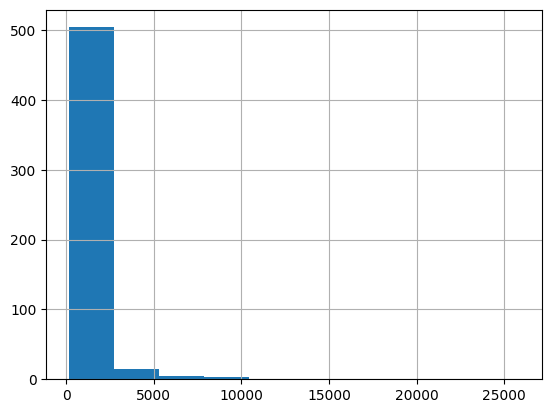

In [26]:
import tiktoken
tokenizer = tiktoken.get_encoding("cl100k_base")
df = pd.read_csv("processed/scraped2.csv", index_col= 0)
df.columns = ['text', 'id']
df = df[pd.notna(df['text'])]
df['no_tokens'] = df.text.apply(lambda x : len(tokenizer.encode(x)))
df['no_tokens'].hist()

In [ ]:
#Just to save the emebddings on to the disk
import google.generativeai as genai
import pandas as pd
import numpy as np
import uuid

def embed_texts_in_batches(texts, batch_size=5, model="models/embedding-001"):
    embeddings_list = []
    texts = [str(text) for text in texts if not isinstance(text, float) or not np.isnan(text)]
    # Split texts into batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        embeddings_batch = embed_batch(batch_texts, model=model)
        embeddings_list.extend(embeddings_batch)

    return pd.DataFrame({"text": texts, "embedding": embeddings_list, "id" :[uuid.uuid4() for _ in range(len(texts))]})

def embed_batch(texts, model):
    return genai.embed_content(
            model=model,
            content=texts,
            task_type="retrieval_document"
        )['embedding']
  

texts = df['text'].tolist()
embeddings_df = embed_texts_in_batches(texts, batch_size=5)
embeddings_df.to_csv('processed/final.csv', index=False)  
print(embeddings_df)

In [12]:
#initialise the connection to the vector store, recreating the collection.
from qdrant_client import QdrantClient
client = QdrantClient(
    url=os.getenv('QDRANT_HOST'),
    api_key=os.getenv('QDRANT_API_KEY'),
)

client.recreate_collection(
    collection_name="University_assistant", 
    vectors_config= VectorParams(size = 768, distance=Distance.DOT)
)

print(client.collection_exists(collection_name='University_assistant'))

C:\Users\NITRO\AppData\Local\Temp\ipykernel_19856\591529067.py:8: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True


In [24]:
import ast
from itertools import islice

embeddings_df = pd.read_csv('processed/final.csv')
embeddings_df['embedding'] = embeddings_df['embedding'].apply(ast.literal_eval)
embeddings_df.to_csv('processed/final.csv')


def batched(iterable, n):
    iterator = iter(iterable)
    while batch := list(islice(iterator, n)):
        yield batch

batch_size = 100

for batch in batched(embeddings_df.to_dict('records'), batch_size):
    ids = [point["id"] for point in batch]
    vectors = [point["embedding"] for point in batch]
    payloads = [{"text": point["text"]} for point in batch]

    client.upsert(
        collection_name="University_assistant",
        points=models.Batch(
            ids=ids,
            vectors=vectors,
            payloads=payloads,
        ),
    )

In [53]:
from typing import List, Any
import google.generativeai as genai
'''Implementation from scratch for a simple RAG model, without using langchain'''

client = QdrantClient(
    url=os.getenv('QDRANT_HOST'),
    api_key=os.getenv('QDRANT_API_KEY'),
)


class GenerateAnswer:
    def __init__(self, ai_model: str, embedding_model: str, client: Any, collection_name: str):
        self.model = ai_model
        self.embedding_model = embedding_model
        self.client = client
        self.collection_name = collection_name

    def embedQuery(self, query: str) -> List[float]:
        """Embed the given query."""
        try:
            embeddedQuery = genai.embed_content(
                model=self.embedding_model,
                content=query,
                task_type="retrieval_query",
            )
            return embeddedQuery['embedding']
        except Exception as e:
            print(f"Error in embedding query: {e}")
            return []

    def similaritySearch(self, query: str, score_threshold: float, limit: int = 2) -> List[str]:
        """Perform similarity search based on the embedded query."""
        try:
            embedded_query = self.embedQuery(query)
            hits = self.client.search(
                collection_name=self.collection_name,
                query_vector=embedded_query,
                limit=limit,
                score_threshold=score_threshold,
            )
            # Extract page_content from each hit
            page_contents = [hit.payload['text'] for hit in hits if hit.payload and 'text' in hit.payload]
            
            return page_contents
        except Exception as e:
            print(f"Error in similarity search: {e}")
            return []

    def promptTemplate(self, query: str) -> str:
        """Generate a prompt template with context."""
        context_list = self.similaritySearch(query, score_threshold=0.3)  # You might want to make this threshold configurable
        context = "\n".join(context_list)  # Join all context items into a single string
        template = f"""
        You are a helpful AI assistant for ashoka university students.
        Answer based on the context provided.
        Context: {context}
        Input: {query}
        Answer:
        """
        return template

    def cookAnswer(self, query: str) -> str:
        """Generate an answer based on the query."""
        try:
            model = genai.GenerativeModel(self.model)
            result = model.generate_content(self.promptTemplate(query))
            return result.text
        except Exception as e:
            print(f"Error in generating answer: {e}")
            return "Sorry, I couldn't generate an answer at this time."               

In [54]:
# Initialize the class
answer_generator = GenerateAnswer(
    ai_model= 	"models/gemini-1.5-flash",
    embedding_model="models/embedding-001",
    client=client,
    collection_name="University_assistant"
)

query = "tell me what is wics computer science"
hits = answer_generator.similaritySearch(query, score_threshold=0.3)
template = answer_generator.promptTemplate(query)
results = answer_generator.cookAnswer(query)
print(hits)
print(results)

C:\Users\NITRO\AppData\Local\Temp\ipykernel_29408\103225483.py:35: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = self.client.search(


Error in generating answer: 429 Resource has been exhausted (e.g. check quota).
['Students’ Guide Department of Computer Science Ashoka UniversityDEPARTMENT OF COMPUTER SCIENCE ,ASHOKA UNIVERSITY This guide was made by the CS Society in consultation with the CS Representative, Seniors, Alumni and Faculty members. The CS Society also acknowledges the work of the Economics Representatives in setting up the Students’ Guide for Economics, parts of which have been referred to while creating this document. DISCLAIMER : The information in this guide is meant to serve as a ready reference for students. Some information may become backdated with changes in curriculum, policies etc. Thus, you are requested to conﬁrm the latest updates from the ofﬁcial website and/or the CS Student Representative before taking any action. First release, Monsoon 2020Contents 1 Overview ......................................................5 1.1 Degree Requirements at Ashoka 5 1.2 GPA and Credit System 5 1.3 CS at 

In [34]:
from qdrant_client import QdrantClient
client = QdrantClient(
    url=os.getenv('QDRANT_HOST'),
    api_key=os.getenv('QDRANT_API_KEY'),
)

client.recreate_collection(
    collection_name= 'University_lassistant', vectors_config= VectorParams(size = 768, distance= Distance.COSINE)
)

embeddings = GoogleGenerativeAIEmbeddings(model='models/embedding-001', google_api_key= os.getenv('GOOGLE_API_KEY'), task_type='retrieval_document')
vector_store = Qdrant(client=client, collection_name='University_lassistant',embeddings=embeddings,)
vector_store.add_texts(df['text'])

C:\Users\NITRO\AppData\Local\Temp\ipykernel_19856\4147650533.py:7: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


['a4e3e5d8cca7493d9085ae4ba47ee14c',
 '05d9a8b5f9b44883b9423340dbac3bae',
 'b0a6c7e7bd6b435989ecbd1b740d27ff',
 '34c17ec76dd8437fa39a05d243072273',
 '40d3fe65af1b45ee97a304f5e65490ec',
 '42309117560147a9b4376814e4abf7e8',
 'b4863cd57b8f470085470d5151e958c4',
 '1e82fd2aef3c470a93696fd9553162bf',
 'aa5ea06ee556414e8220a2e7454af8ca',
 '8e1ce71fa5844b70a39ab3b5230c3610',
 '89eeaaa5955348fa84367dd515829e60',
 '1078aebe03fc47099400a332e073ed73',
 'f5380b8d9e5a4834a8f9139bc59171e3',
 '45388cc635f3410d89cc841ac9b91c81',
 '2637b3ac705049a8bb148707e51158e0',
 '0a45f66e70a24837829a214b02e35879',
 '074eb08ba0724d5aad7a07fe5090eab8',
 'b039de4f8eca4192b6aaa8144569d495',
 '32feb1e430504f62979c5d26e083c523',
 '7e2425fea9a7477ba55bc2d4f24b62c6',
 'a5a31b33f2d14c39aad9633367ba4d11',
 '4741006b3fe04856b4a49f0c49c0e037',
 '792418ab156b487cb9b33b08e68c885e',
 'cf409ec803d0406c92aad1c8ae220dcb',
 '9a19d3d9e34f49ed823ced1dcb6e0032',
 '092d53ca888849229858aa8aa62c3557',
 '183626d25f8f4219bbf2548c9cdcbb7b',
 

In [44]:
#Working the vector store to asses the retrievals
client = QdrantClient(
    url=os.getenv('QDRANT_HOST'),
    api_key=os.getenv('QDRANT_API_KEY'),
)

embeddings = GoogleGenerativeAIEmbeddings(model='models/embedding-001', google_api_key= os.getenv('GOOGLE_API_KEY'), task_type='retrieval_query')
doc_store = Qdrant(client=client, 
                   collection_name='University_lassistant',
                   embeddings= embeddings)
#Examples
hits = client.search(
	collection_name="University_lassistant",
	query_vector=embeddings.embed_query("computer science department handbook"),
	limit=2
)
for hit in hits:
	print(hit.payload, "score:", hit.score)

C:\Users\NITRO\AppData\Local\Temp\ipykernel_29408\3948656232.py:12: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


{'page_content': 'Students’ Guide Department of Computer Science Ashoka UniversityDEPARTMENT OF COMPUTER SCIENCE ,ASHOKA UNIVERSITY This guide was made by the CS Society in consultation with the CS Representative, Seniors, Alumni and Faculty members. The CS Society also acknowledges the work of the Economics Representatives in setting up the Students’ Guide for Economics, parts of which have been referred to while creating this document. DISCLAIMER : The information in this guide is meant to serve as a ready reference for students. Some information may become backdated with changes in curriculum, policies etc. Thus, you are requested to conﬁrm the latest updates from the ofﬁcial website and/or the CS Student Representative before taking any action. First release, Monsoon 2020Contents 1 Overview ......................................................5 1.1 Degree Requirements at Ashoka 5 1.2 GPA and Credit System 5 1.3 CS at Ashoka 6 1.3.1 Programs Offered ................................

In [29]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import GoogleGenerativeAI

retriever = doc_store.as_retriever(search_kwargs = {"k": 5})
llm = GoogleGenerativeAI(model='models/gemini-2.0-flash-exp', google_api_key=os.getenv('GOOGLE_API_KEY'))

template = """
you are a helpful ai assistant.
answer based on the context provided.you need not look for the exact similarity from the context.
context: {context}
input: {input}
answer:
"""
prompt = PromptTemplate.from_template(template)
combine_docs_chain = create_stuff_documents_chain(llm, prompt)
retrieval_chain = create_retrieval_chain(retriever, combine_docs_chain)
response = retrieval_chain.invoke({"input": "I am a second year first sem student, wanting to explore major in computer science, what courses should I take this semester?"})
print(response["answer"])


Based on the "A CS Major’s recommended path", if you are in your third semester and want to major in Computer Science, you should consider taking:

- Probability and Statistics
- Computer Organization and Systems
- Advanced Programming



In [2]:
def getSource():
    #add the metadata field to the database
        #to do this:
            #iterate through the directory, get the file names, process it and make it a link
            #add a column to the database calling metafield
            #now when retrieving the page content, retrieve the metadata as well, and return it along with the page content
    pass

def generateSimilarQ():
    #store the user query into a variable
        #now before the api call is made to generate the answer(which is done before querying the vector store)
        #query the google api to generate one or more questions similar to it
        #then pass in this extra question to the prompt template, then make the call to google API
    pass

def getEmail():
    #listen to gmail API, make a script which will run every 3 days, get the text of email, embed it
    #add to the data base
    pass